### Import packages

In [1]:
import folium
import functools
import geopandas as gpd
import io
import logging
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from opentnsim import core as core_module
from opentnsim import graph as graph_module
from opentnsim import lock as lock_module
from opentnsim import model as model_module
from opentnsim import output as output_module
from opentnsim import vessel as vessel_module
from opentnsim import vessel_traffic_service as vessel_traffic_service_module
import os
import pandas as pd
import pickle
import pyproj
import requests
from shapely.geometry import Point,LineString,Polygon
from shapely.geometry.collection import GeometryCollection
from shapely.ops import transform, linemerge, split, snap
import simpy
import yaml

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
%matplotlib inline

# Basic lock simulation
Remember the exercise on the capacity of a lock that was given by Arne van der Hout? Instead of calculating the lock capacity by hand, we can actually simulate locks using the software of OpenTNSim. How does this work?

First, we create an environment

In [2]:
simulation_start = pd.Timestamp('2024-01-01')
env = simpy.Environment(initial_time=simulation_start.timestamp())

#Also we need to add a time
env.simulation_start = simulation_start

We need to create a graph and add to the environment

In [3]:
#We need to create a network over which the vessels will sail
node_A = graph_module.Node(name='A',geometry=Point(0,0))
node_B = graph_module.Node(name='B',geometry=Point(400,0))
node_C = graph_module.Node(name='C',geometry=Point(800,0))
edges = [(node_A,node_B),(node_B,node_C)]
FG = graph_module.DiGraph(edges=edges,crs='EPSG:28992').graph

#We need to add the graph to the environment:
env.FG = FG

#In order from ships to know where they are going we need to add an VTS to the environment
env.vessel_traffic_service = vessel_traffic_service_module.VesselTrafficService(env=env)

Now we need to create the lock infrastructure

In [4]:
# #We can now add infrastructure to the network
lock_I = lock_module.IsLockComplex(env=env,
                                   name='Lock I',
                                   start_node='A',
                                   end_node='B',
                                   lock_length = 120,
                                   lock_width = 18,
                                   lock_depth = 6,
                                   lineup_area_A_length=120,
                                   lineup_area_B_length=0,
                                   effective_lineup_area_B_length=120,
                                   levelling_time=1500,
                                   distance_doors_A_from_waiting_area_A=140,
                                   distance_doors_B_from_waiting_area_B=0,
                                   distance_waiting_area_A_from_start_node=140,
                                   distance_waiting_area_B_from_end_node=0,
                                   distance_lineup_area_A_to_lock_doors_A=20,
                                   distance_lineup_area_B_to_lock_doors_B=0)

lock_II = lock_module.IsLockComplex(env=env,
                                    name='Lock II',
                                    start_node='B',
                                    node_open='B',
                                    end_node='C',
                                    lock_length = 120,
                                    lock_width = 18,
                                    lock_depth = 6,
                                    lineup_area_A_length=0,
                                    lineup_area_B_length=120,
                                    effective_lineup_area_A_length=120,
                                    levelling_time=1500,
                                    distance_doors_A_from_waiting_area_A=0,
                                    distance_doors_B_from_waiting_area_B=140,
                                    distance_waiting_area_A_from_start_node=0,
                                    distance_waiting_area_B_from_end_node=140,
                                    distance_lineup_area_A_to_lock_doors_A=0,
                                    distance_lineup_area_B_to_lock_doors_B=20)

Now we need to add a vessel

In [5]:
#We create a type element that schematisizes a vessel
Vessel = type('Vessel',(lock_module.HasLockComplex, #The vessel should interact with a lock chamber
                        vessel_module.IsVessel),{}) #The vessel should have output

#Using the element, we need to give the following information to the vessel
vessel = Vessel(env=env,
                name='Vessel', 
                origin='A',
                destination='C',
                type='inland vessel',
                L=100,
                B=15,
                T=5,
                H=4,
                v=4,
                arrival_time=pd.Timestamp('2024-01-01'),)

We can now create a process in the environment in which the vessel will move (from node A to node B)

In [6]:
env.process(vessel.move())

<Process(move) object at 0x1aa4b8bd790>

Run the simulation

In [7]:
env.run()

We can now analyse the logbook of the vessel

In [8]:
vessel_df = pd.DataFrame(vessel.logbook)
vessel_df

,Message,Timestamp,Value,Geometry
0,Sailing from node A to node B start,2024-01-01 01:00:00.000000,"{'origin': 'A', 'destination': 'C', 'route': [...",POINT (3.3135576329102165 47.97476588466147)
1,Sailing to start of line-up area start,2024-01-01 01:00:00.000000,"{'origin': 'A', 'destination': 'C', 'route': [...",POINT (3.3135576329102165 47.97476588466147)
2,Sailing to start of line-up area stop,2024-01-01 01:00:35.000000,"{'origin': 'A', 'destination': 'C', 'route': [...",POINT (3.3154320350738398 47.97480082773064)
3,Sailing to position in line-up area start,2024-01-01 01:00:35.000000,"{'origin': 'A', 'destination': 'C', 'route': [...",POINT (3.3154320350738398 47.97480082773064)
4,Sailing to position in line-up area stop,2024-01-01 01:00:58.333333,"{'origin': 'A', 'destination': 'C', 'route': [...",POINT (3.3163692371038613 47.974818287795)
5,Sailing to end of line-up area start,2024-01-01 01:00:58.333333,"{'origin': 'A', 'destination': 'C', 'route': [...",POINT (3.3163692371038613 47.974818287795)
6,Sailing to end of line-up area stop,2024-01-01 01:01:53.888889,"{'origin': 'A', 'destination': 'C', 'route': [...",POINT (3.3170386675121204 47.97483075458781)
7,Sailing to first set of lock doors start,2024-01-01 01:01:53.888889,"{'origin': 'A', 'destination': 'C', 'route': [...",POINT (3.3170386675121204 47.97483075458781)
8,Sailing to first set of lock doors stop,2024-01-01 01:02:16.111111,"{'origin': 'A', 'destination': 'C', 'route': [...",POINT (3.3173064397656544 47.974835740212534)
9,Sailing to assigned location in lock start,2024-01-01 01:02:16.111111,"{'origin': 'A', 'destination': 'C', 'route': [...",POINT (3.3173064397656544 47.974835740212534)


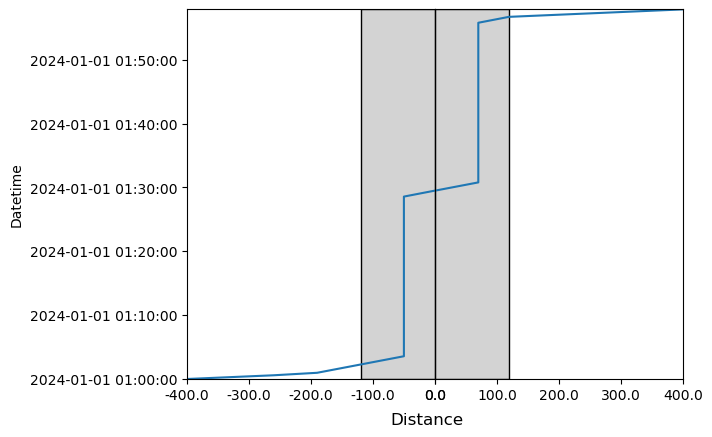

In [9]:
fig,axes = plt.subplots(1,2)
ylim = (vessel_df.iloc[0]['Timestamp'],vessel_df.iloc[-1]['Timestamp'])
lock_I.create_time_distance_diagram([vessel],ax=axes[0],x_offset=-200,accuracy=200,ylim=ylim)
lock_II.create_time_distance_diagram([vessel],ax=axes[1],x_offset=200,accuracy=200,ylim=ylim)
axes[0].set_xlabel('')
for ax in axes[1:]:
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
ylim = (vessel_df.iloc[0]['Timestamp'],vessel_df.iloc[-1]['Timestamp'])
plt.subplots_adjust(wspace=0)
fig.supxlabel('Distance');

And we can analyse the logbook of the lock

In [10]:
lock_df = pd.DataFrame(lock_I.logbook)
lock_df

,Message,Timestamp,Value,Geometry
0,Lock doors closing start,2024-01-01 01:03:33.888889,{'visiting_vessels': [<__main__.Vessel object ...,A
1,Lock doors closing stop,2024-01-01 01:03:33.888889,{'visiting_vessels': [<__main__.Vessel object ...,A
2,Lock chamber converting start,2024-01-01 01:03:33.888889,{'visiting_vessels': [<__main__.Vessel object ...,A
3,Lock chamber converting stop,2024-01-01 01:28:33.888889,{'visiting_vessels': [<__main__.Vessel object ...,B
4,Lock doors opening start,2024-01-01 01:28:33.888889,{'visiting_vessels': [<__main__.Vessel object ...,B
5,Lock doors opening stop,2024-01-01 01:28:33.888889,{'visiting_vessels': [<__main__.Vessel object ...,B
